## Ensemble Learning

---
0. 簡言
1. Bagging
2. Boosting
3. Stacking
4. 總結
5. Reference
---

### 0. 簡言

近幾年來，Ensemble Learning(集成學習)幾乎是火熱地襲捲而來。

無論是在 Kaggle 上的各種競賽、或是全世界(包括台灣)各企業舉辦的比賽，只要是牽扯到「預測」或「分類」的問題，在不考慮變數解釋的狀況下，如果不套入 Ensemble Learning 的技巧，就無法獲得很好的名次。

例如，現在 Kaggle 上世界排名第一的 [Giba](https://www.kaggle.com/titericz) ，就曾在 2015 年由 Otto 舉辦的比賽中，使用了 38 個模型，搭配 Feature Engineering 以及 Stacking 的技巧，建立三層(1st level: 33 models; 2nd level: 3rd level: composed weights) 的預測架構，並獲得第一名，相當精彩且值得參考：[1st PLACE - WINNER SOLUTION - Gilberto Titericz & Stanislav Semenov](https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335)

此外，由美國最大問答論壇 Quora 舉辦的問題配對比賽中，當時第一名的 [Maximilien@DAMI](https://www.kaggle.com/colonelcarotte) 也分享他的建模心得：在使用一般經典的類神經網路下，結合 Stacking 的技巧，建構出四層的文字比對架構：[Quora Question Pairs 競賽冠軍經驗分享：採用 4 層堆疊，經典模型比較給力](http://bangqu.com/12Ks1D.html)

所謂的 Ensemble Learning ，其實就是「三個臭皮匠，勝過一個諸葛亮」的概念，希望藉由團隊合作，結合多種模型的表現，提升最後的預測/分類結果。一般有三種常見的架構：

Bagging (Bootstrap aggregating)

Boosting

Stacking (short for [stacked generalization](http://machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf), also called meta ensembling)

這三種架構在結合模型時使用的概念並不一樣，因此本文中會依序介紹這三種方法的概念與實踐方式(用 Python)，並示範基於此概念而衍生出來的模型程式如何撰寫： Random Forest(隨機森林) 跟 Gradient Boosting Machine (梯度推進器)

### 資料

這裡拿的是機台預測壽命的資料，是 IEEE PHM 2012 Prognostic challenge 的資料，可以從https://ti.arc.nasa.gov/c/13/. 下載，其中包含了三個機台設定值及 21 個 sensor 收集的資料，從初始狀態記錄到機台損壞全部有218個引擎，從開始運作直到毀損的時間序列（每個引擎的初始狀態與操作條件有所不同），其中每個多元時間序列包含了3 個操作設定與21 個感測量測值。

要注意的是，依變數會是 RUL(Remain useful life)，主要是從每個機台 (id) 最大的cycle回推而來的，代表還有幾個cycle可以存活，自變數則是當下的時間(cycle)，及不同的感測量測值。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_table("train.txt",header=None,sep=' ')
df = df.drop([26, 27], axis=1)
df.columns = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [3]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [4]:
df_max_cycle = pd.DataFrame(df.groupby("id")["cycle"].max())
df_max_cycle.reset_index(level=0 , inplace=True)
df_max_cycle.columns = ['id', 'last_cycle']
df_max_cycle.describe()

,id,last_cycle
count,218.000000,218.000000
mean,109.500000,210.633028
std,63.075352,43.595578
min,1.000000,128.000000
25%,55.250000,177.000000
50%,109.500000,209.500000
75%,163.750000,236.000000
max,218.000000,357.000000


In [5]:
df = pd.merge(df, df_max_cycle, on="id")
df["rul"] = df["last_cycle"] - df["cycle"]
df.drop(["last_cycle"], axis=1 , inplace=True)
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,218


In [6]:
df.shape

(45918, 27)

### 1. Bagging

Bootstrap aggregating (Bagging)，從字面上來看，就是將資料裝成一個袋子一個袋子(Bag)，然後將每個袋子的結果結合在一起。

演算法上，是將樣本重複抽樣(取後放回)，產生多個子資料集(Subsets)後，依序建立多個模型，最後再將所有模型的結果彙整在一起。如果是預測問題(Regression Problem)，那就把所有結果平均起來(Average)；如果是分類問題(Classification Problem)，那就用投票法(Voting)，判斷哪個類別出現最多次。如下圖所示：

![Image1](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R16/1.png)

在模型 Bias 跟 Variance 的議題上，Bagging 的手法有助於降低 variance。

當每個子集資料在建模的時候，每個模型若獨自拿出來看，會發現都是一個「強模型」(較複雜的模型)，具有低 bias 跟高 variance 的特性；而如今，我們把不同高 variance 的模型結合在一起後，因為是平均(投票)的概念，其結果就會趨近於整體的平均表現，因此 variance 就不會太大。([為什麼說bagging是減少variance，而boosting是減少bias?](https://www.zhihu.com/question/26760839))

這就是 Bagging 的概念：用抽樣資料建構的模型，會有好有壞，因此取平均(或投票法)來獲得較穩定(lower variance)的平均表現。


#### Random Forest

所謂的隨機森林，就是運用 Bagging + CART決策樹，也就是說Model-1 ~ Model-n全都都是用決策樹來建模，而這麼多棵的樹組合在一起，所以才稱為「森林」。

要注意的是，隨機森林在抽樣過程中，不只是對 Row 進行抽樣，同時也會對 Column 抽樣，因此產生的子集資料，其實是對欄跟列抽樣後的結果。之後再針對這些子集資料，各自訓練一棵決策樹，形成隨機森林。

事實上，在面對資料中有共線性(collinearity)跟類別不平衡(Class Imbalance Problem)，而這些問題會對預測結果造成不良影響時(若是探討對「變數解釋性」的影響，則需要用 Lasso 或 Stepwise 來解決)，隨機森林是倍受青睞的演算法。其概念應該不難理解：「對 Row 抽樣時，可以部份解決類別不平衡來影響預測的問題；對 Column 抽樣時，可以部份解決共線性來影響預測的問題」

In [7]:
random.seed(123)
test_index = random.sample(list(range(1,219,1)), k=int(df["id"].unique().shape[0]*0.3))
train_index = []
for i in range(1,219,1):
    if i not in test_index:
        train_index.append(i)

In [8]:
train_df = df[df["id"].isin(train_index)]
test_df = df[df["id"].isin(test_index)]
x_train = train_df.drop(["id","rul"], axis=1)
y_train = train_df["rul"]
x_test = test_df.drop(["id","rul"], axis=1)
y_test = test_df["rul"]

In [9]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=1)

rf.fit(x_train, y_train)

y_test_predict = rf.predict(x_test)
y_train_predict = rf.predict(x_train)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
print('MSE training: %.3f, MSE testing: %.3f' % (
      (train_mse), (test_mse)))
print('RMSE training: %.3f, RMSE testing: %.3f' % (
      (train_mse**0.5), (test_mse**0.5)))

MSE training: 159.100, MSE testing: 1215.392
RMSE training: 12.613, RMSE testing: 34.862


In [10]:
def plot_features_weights(model, weights, feature_names):
    

    (px, py) = (8, 10) 
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W_df = W.sort_values(by='Weights', ascending=True)
    W_df.tail(10).plot(kind='barh', color='r', figsize=(px,py))
    plt.xlabel(model)
    plt.gca().legend_ = None

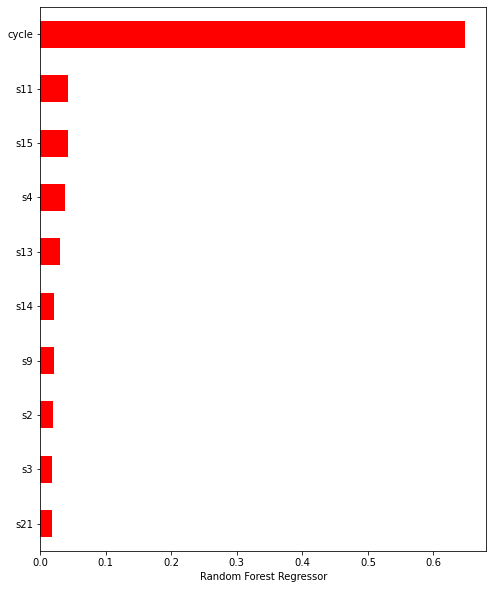

In [11]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, x_train.columns)

random forest 是由許多的 Decision tree 構成，並且有可以透過畫圖的功能把每棵樹畫出來

In [12]:
rf.estimators_[0:5]

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1791095845, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2135392491, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impur

這裡有一個建模中都會遇到的重要議題：「要決定多少決策樹？」(也就是n_estimators要設定多少？)

而要決定隨機森林的最佳棵樹，可以透過 grid search 的方式去找尋超參數，並且比較 validation 的 mse，當然如果要避免超參數只是 overfitting validation data，可以利用 cross-validation 進一步的找尋能夠代表全部資料的超參數。

而在 grid search 時超參數可以利用等比的方式來設定，由於超參數太過接近可能差異不大，找尋的時間需要非常的多，利用等比的方式可以找到更好的級數，找到之後可以在細調附近的超參數找尋到最好的數字。

In [13]:
gridsearch = np.round(np.logspace(1,3.2,10),0)
gridsearch

array([  10.,   18.,   31.,   54.,   95.,  167.,  293.,  514.,  903.,
       1585.])

In [14]:
c_list = []
train_f1 = []
val_f1 = []
for c in gridsearch:
    rfc = RandomForestRegressor(n_estimators=int(c),random_state=0,n_jobs=-1).fit(x_train, y_train)
    y_train_pred = rfc.predict(x_train)
    y_val_pred = rfc.predict(x_test)
    c_list.append(c)
    train_f1.append(mean_squared_error(y_train, y_train_pred))
    val_f1.append(mean_squared_error(y_test ,y_val_pred))
    print(c)

10.0
18.0
31.0
54.0
95.0
167.0
293.0
514.0
903.0
1585.0


In [15]:
grid_df = pd.DataFrame(c_list,columns=["c"])
grid_df["train_mse"] = train_f1
grid_df["val_mse"] = val_f1
grid_df.sort_values(by="val_mse",ascending=True)

,c,train_mse,val_mse
9,1585.0,156.939060,1211.452400
8,903.0,157.209114,1212.269016
7,514.0,157.560705,1214.346612
6,293.0,158.664820,1216.514825
5,167.0,160.712759,1220.229490
4,95.0,164.720731,1225.514871
3,54.0,169.704972,1240.400668
2,31.0,179.674627,1256.306397
1,18.0,195.770304,1279.089170
0,10.0,227.403798,1337.647843


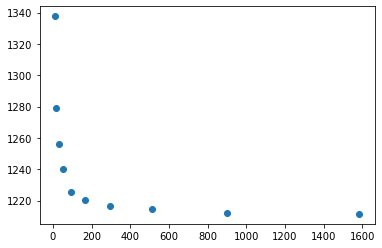

In [16]:
plt.scatter(grid_df["c"], grid_df["val_mse"])

這裡發現 1585 棵樹最多數的時候 mse 越小，思考一下 bagging 的機制，其實越多樹很可能會有更低 mse，但是我們另外要觀察每個的超參數的差異性，可以發現到後面 mse的差距變得非常小，其實 293 棵樹就已經足夠了。

在決定好 n_estimators 的數量後，另一個超參數 max_features 其實也可以去 Tune，這個參數代表每次抽樣時需要抽「多少個變數」的意思。

並根據下面的結果與圖，得知每次抽樣時「抽10個變數」會是比較好的選擇：

In [17]:
len(x_train.columns)

25

In [18]:
gridsearch = [5,10,15,20,25]

In [19]:
c_list = []
train_f1 = []
val_f1 = []
for c in gridsearch:
    rfc = RandomForestRegressor(n_estimators=293,max_features=c,random_state=0,n_jobs=-1).fit(x_train, y_train)
    y_train_pred = rfc.predict(x_train)
    y_val_pred = rfc.predict(x_test)
    c_list.append(c)
    train_f1.append(mean_squared_error(y_train, y_train_pred))
    val_f1.append(mean_squared_error(y_test ,y_val_pred))
    print(c)

5
10
15
20
25


In [20]:
grid_df = pd.DataFrame(c_list,columns=["c"])
grid_df["train_mse"] = train_f1
grid_df["val_mse"] = val_f1
grid_df.sort_values(by="val_mse",ascending=True)

,c,train_mse,val_mse
1,10,155.305963,1198.760288
0,5,155.198962,1199.528486
2,15,156.705465,1201.888552
3,20,157.076148,1209.597764
4,25,158.664820,1216.514825


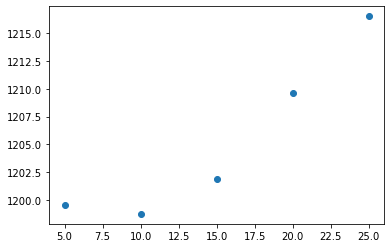

In [21]:
plt.scatter(grid_df["c"], grid_df["val_mse"])

可以跟一開始的模型比，會發現 mse 不管在 train / valid 都更小了

### 2. Boosting

跟 Bagging 使用多個「強模型」不同， Boosting 會強調使用上需要多個「弱模型」才可以。

其概念用「三個臭皮匠，勝過一個諸葛亮」來形容最為貼切，也就是需要有多個非常弱的「臭皮匠」，而這些臭皮匠彼此是互補的。也就是說： M2 模型要能辦到 M1 模型所辦不到的， M3 要辦到 M2 所辦不到的……。

會強調要「弱模型」，是因為模型本身如果「有點強」還不行。以最簡單的說法來說明：當模型都「有點強」時，彼此就會開始打架，造成有意見不合的狀況(這在人類社會中很常遇見吧XD)。

以人類分工合作的概念來說，如果每個人只會一項技能，那只要好好專司自己的職責，便不會去插手其他人的事務；但如果今天大家都是碩士博士，那對於某個問題，便會有許多人都給意見，有時候反而會造成干擾。

模型也是這樣的，今天 M1 M2 M3 如果太複雜(太強)，那彼此之間就會互相干擾，影響最後預測/分類結果；唯有彼此都是「弱模型」，才能好好專注在自己本身的預測/分類，然後再把彼此的成果結合一起，這就是 Boosting 的概念。(當然以計算效率的考量，這樣做也比較快)(In boosting, why are the learners “weak”?)

在演算法中，要從資料中找 M1 M2 M3…的模型是有順序的，概念跟 Bagging完全不一樣：

- 在 Bagging 時，我們是將資料做抽樣，因此獲得許多子集資料，並各別建模後，把結果平均/投票。

- 在 Boosting 時，一開始先建一個簡單的模型 M1 ，此時會有預測錯誤的資料，把這些資料的權重加大，建 M2 模型，然後又會有預測錯的資料，再把資料的權重加大，建 M3 模型…

演算法的概念如下圖所示：

![Image2](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R16/2.png)

在模型 Bias 跟 Variance 的議題上，Boosting 的手法有助於降低 bias。

由於使用上是拿「弱模型」來用，這些弱模型其實是高 bias 跟 低 variance 的，並且每次迭代的時候，都會基於先前的模型上進行優化(用梯度下降法，決定這次模型建在哪裡能使損失函數下降最多)。既然是降低損失函數，表示過程中會越來越逼近實際值，換句話說，就是逐漸降低 bias 的意思。([为什么说bagging是减少variance，而boosting是减少bias?](https://www.zhihu.com/question/26760839))

(由於使用的資料並非分類問題，因此難以用本資料進行 Boosting 的模擬實踐。接下來會介紹以 Boosting 為基準發展出的演算法，Gradient Boosting Machine。)

### Gradient Boosting Machine(XGboost)

所謂的 GBM 算是一種概念，是將梯度下降法(Gradient Descending)跟 Boosting 套件節合在一起的演算法，而後面的 Machine 指不特定的模型，只要能用梯度下降法找尋方向的模型都可以。

目前市面上，如果使用 gbm 的套件，基本上都是 Tree-based 為主，也就是將數百個弱決策樹(CART)，跟梯度下降法和 Boosting 結合在一起。

而 XGboost 又有些許不同，是本來的 Gradient Boosting Decision Tree(GBDT)的改良版本，細節處可以參考這篇文章：[机器学习算法中GBDT和XGBOOST的区别有哪些？](https://www.zhihu.com/question/41354392)。

如果有在關注 Kaggle 的人，就會知道近年來 XGboost 被譽為是「Kaggle 神器」。原因無他，就是因為每年的得名隊伍，使用 XGboost 的團隊基幾乎大多數！(更多關於 XGboost 的介紹可以參考這篇：[机器学习算法中GBDT和XGBOOST的区别有哪些？](https://www.zhihu.com/question/41354392))

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
gb = GradientBoostingRegressor(random_state=1)

gb.fit(x_train, y_train)

y_test_predict = gb.predict(x_test)
y_train_predict = gb.predict(x_train)

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
print('MSE training: %.3f, MSE testing: %.3f' % (
      (train_mse), (test_mse)))
print('RMSE training: %.3f, RMSE testing: %.3f' % (
      (train_mse**0.5), (test_mse**0.5)))

MSE training: 1226.095, MSE testing: 1251.829
RMSE training: 35.016, RMSE testing: 35.381


In [24]:
gb

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

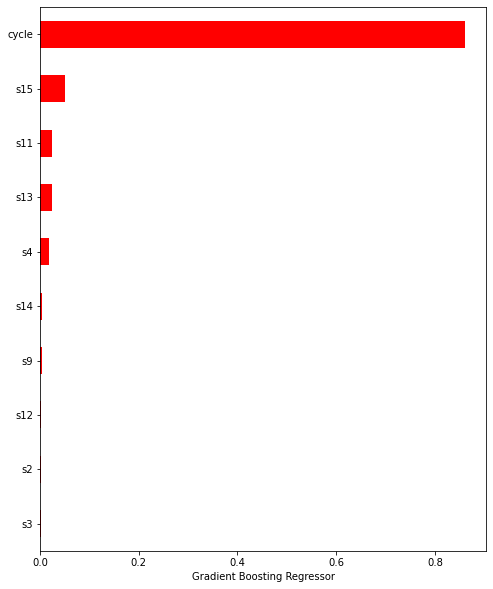

In [25]:
plot_features_weights('Gradient Boosting Regressor', gb.feature_importances_, x_train.columns)

同樣利用 grid search 的放是找出最佳的決策樹數量

In [26]:
gridsearch = np.round(np.logspace(1,3.2,10),0)
gridsearch

array([  10.,   18.,   31.,   54.,   95.,  167.,  293.,  514.,  903.,
       1585.])

In [27]:
c_list = []
train_f1 = []
val_f1 = []
for c in gridsearch:
    rfc = GradientBoostingRegressor(n_estimators=int(c),random_state=0).fit(x_train, y_train)
    y_train_pred = rfc.predict(x_train)
    y_val_pred = rfc.predict(x_test)
    c_list.append(c)
    train_f1.append(mean_squared_error(y_train, y_train_pred))
    val_f1.append(mean_squared_error(y_test ,y_val_pred))
    print(c)

10.0
18.0
31.0
54.0
95.0
167.0
293.0
514.0
903.0
1585.0


In [28]:
grid_df = pd.DataFrame(c_list,columns=["c"])
grid_df["train_mse"] = train_f1
grid_df["val_mse"] = val_f1
grid_df.sort_values(by="val_mse",ascending=True)

,c,train_mse,val_mse
6,293.0,1104.230371,1222.994481
5,167.0,1166.056601,1230.172922
7,514.0,1038.983851,1231.327505
8,903.0,954.376979,1239.865615
4,95.0,1232.366040,1254.386394
9,1585.0,842.315363,1257.699477
3,54.0,1312.096148,1310.652554
2,31.0,1410.213841,1412.560886
1,18.0,1591.766452,1608.557503
0,10.0,1994.249709,2033.979133


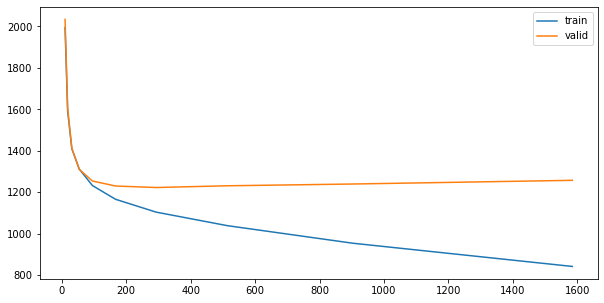

In [29]:
plt.figure(figsize=(10,5))
plt.plot(grid_df["c"], grid_df["train_mse"],label="train")
plt.plot(grid_df["c"], grid_df["val_mse"],label="valid")
plt.legend()

可以跟一開始的模型比，會發現 mse 不管在 train / valid 都更小了

一般來說，Train 的表現會比 Validation 還要好，這時有兩種情況要思考：

1.如果 Train 跟 Validation 相近，表示模型其實還可以訓練得更好(更複雜)，藉由提高 Train 的表現，觀察 Validation 是否有機會提升，因此可以調以下參數，以提高模型複雜度的概念進行：


- max_depth 調高 1 單位 (最建議調這個)

- max_features 調高比例 (調這個也不錯)

- learning rate調低


2.如果 Train 比 Validation 好太多，就表示有 ovrfitting的問題發生，這時候上面的參數就要反過來調，以降低模型複雜度的概念來進行。


### 3. Stacking

最後要討論的 emsemble 技巧是 stacking，其概念很簡單：

「在訓練多個模型、得到多個預測值/分類結果後，與其使用投票法(hard voting)或平均法(average)將這些結果整合(ensemble)起來，為何不多訓練一個模型來做這樣的整合呢？」

下圖展現了 Stacking 的核心概念：

「今天已經訓練好三個機器學習的模型，分別是 linear regression, support vector regression 跟 CART decision tree。當有一筆新資料需要預測時，會各自得到三個預測值(y1, y2, y3)，然後接下來作為最終模型(又稱 meta-model, blender, meta learner)的輸入值，得到最終預測結果(y.final)」

![Image3](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R16/3.png)

這跟傳統上的做法不太一樣，我們直覺上會把(y1, y2, y3)的結果直接拿來平均(預測問題)或投票法(分類問題)，得到最後的結果。

不過 Stacking 採用另一個模型(blender)來取代這樣的概念。換句話說，也就是「把本來的預測結果再進一步做預測」的感覺。

因此，Stacking 的演算法可以分成兩個階段，應該不難理解：

1. Stacking：先訓練多個初始模型，其預測結果叫做 Meta-Data，作為最終模型(Meta-Model; Blender)的的輸入。

2. Blending：最終模型會取得 Meta-Data ，整合出最後結果(Predicted Results)。

不過當打算開始使用 Stacking 的技巧來建模，想必會立刻遇到瓶頸：「咦？那我要怎麼訓練初始模型跟最終模型？並得到所謂的 meta-data？」

如果是訓練初始模型，想必大家都會，因為原始資料直接丟下去訓練就可以。

不過現在卻有一個問題：「要怎麼訓練第二階段的最終模型 (Meta-Model) 呢？」

感覺上，也需要有一筆訓練資料，才能訓練 Meta-Model…事實上，這樣想是對的，只不過這時的訓練資料，又稱Meta-X，會從初始模型的預測結果而來…只是怎麼來呢？

所以讓我們先看初始模型的訓練，跟取得 Meta-Data(Meta-X 跟 Meta-Y) 吧！

基本上，在訓練初始模型取得 Meta-Data 時，會搭配類似 K-folds 的技巧，將訓練資料切割成數個子集資料(Subsets)。

在上一張圖中我們有三個模型，這裡舉第一個模型(Linear Regression 線性迴歸)為例，如下圖(大圖下載)：

![Image4](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R16/4.png)

假設將訓練資料(Train Data)分成三個子集資料(3-folds)，當然不一定要三個，依情況而定。

因此，從訓練資料(Train Data)中分割而出資料子集，綠色部分會用來訓練模型，紅色部分會拿來預測並取得 Predict_X。

由圖中可以得知，概念就是把本來的(Train Data)，經由預測後，全轉換成 Predict_X 的狀態，這時又被稱作 Meta-X，會當成最終模型(Meta-Model)的訓練資料。

另外，我們手中還有原始的測試資料(Test Data)，丟入模型預測後會得到 Predict (紫色部分)。

但由於我們一開始把資料分成三份，所以會有三個模型，也會得到三組測試資料的預測結果，這時就直接用平均法(連續問題)/投票法(分類問題)，將這三組預測結果整合起來，變成 Predict_Y 的狀態，又被稱作 Meta-Y，並丟給最終模型(Meta-Model)來預測。

換句話說，當擁有多個模型時，我們必須各自取得每個模型的 Meta-X 跟 Meta-Y，來作為最終模型(Meta-Model)的訓練及測試資料集。

因此，整個 Stacking 的概念可以用下圖表示：

![Image5](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R16/5.png)

當然，上面示範兩階段的狀況而已。實際上在 Kaggle 比賽中，很常看見發展成三、四階段的 Stacking 模型。

例如，在簡言中提及的得獎隊伍，就是使用多層階段的 Stacking 模型(同時搭配 Feature Engineering 的技巧)。

下一小節，會用 Python 實踐 Stacking 的概念，使用的模型會跟上面的圖例和流程一樣，可以程式碼及概念相互比對學習。

### Python Code for Stacking Implementg

### 第一階段 (Stacking)

一開始，我們把訓練資料 Train 分成三份(3-folds)：

In [30]:
len(test_index)/2

32.5

In [31]:
test_index[0:32]

[14,
 69,
 23,
 197,
 105,
 217,
 28,
 10,
 98,
 138,
 144,
 86,
 88,
 218,
 41,
 35,
 87,
 208,
 207,
 180,
 63,
 42,
 1,
 112,
 216,
 153,
 97,
 18,
 2,
 81,
 188,
 115]

In [32]:
train_df = df[df["id"].isin(train_index)]
test_df = df[df["id"].isin(test_index[:32])]
stack_df = df[df["id"].isin(test_index[32:])]
x_train = train_df.drop(["id","rul"], axis=1)
y_train = train_df["rul"]
x_stack = stack_df.drop(["id","rul"], axis=1)
y_stack = stack_df["rul"]
x_test = test_df.drop(["id","rul"], axis=1)
y_test = test_df["rul"]

#### 分別建立三個模型

分別是linear regression及前面調好超參數的兩個模型

1. random forest

In [33]:
rf = RandomForestRegressor(n_estimators=293,max_features=10,random_state=0,n_jobs=-1).fit(x_train, y_train)

2. gradient boosting

In [34]:
gb = GradientBoostingRegressor(n_estimators=293,random_state=0).fit(x_train, y_train)

3. linear regression

In [35]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x_train, y_train)

分別利用三個模型去預測 stacking 的資料

In [36]:
clf1 = rf.predict(x_stack)
clf2 = gb.predict(x_stack)
clf3 = lr.predict(x_stack)

In [37]:
stack_train = []
for i in range(len(y_stack)):
    stack_train.append([clf1[i], clf2[i], clf3[i]])

In [38]:
stack_train[0:10]

[[208.2320819112628, 207.70609038416512, 183.93365530198207],
 [208.84641638225256, 221.43373617050187, 192.17166646255646],
 [203.3071672354949, 214.6870453540401, 188.3417806282523],
 [198.90102389078498, 202.5311784981612, 181.30975120700896],
 [208.71672354948805, 214.63871340789336, 194.64430417475523],
 [190.2764505119454, 198.92456323996439, 183.27085765224183],
 [196.03754266211604, 202.527846559721, 197.81401016417658],
 [213.66894197952217, 196.4637679512504, 175.51769712939858],
 [203.84982935153585, 206.1602213359495, 188.75079401035327],
 [195.47440273037543, 204.5127659727982, 186.51742455735803]]

訓練 stacking model，把三個模型預測出來的東西當作 X 來建模

In [39]:
stack_model = LinearRegression().fit(stack_train, y_stack)

In [40]:
stack_model.coef_

array([0.39789625, 0.42389407, 0.25670426])

從係數可以看出不同模型的重要程度，其中 gradient boosting 是最重要的

利用預測 stacking model 做預測

In [41]:
def ensemble_predict(x_test):
    clf1_test = rf.predict(x_test)
    clf2_test = gb.predict(x_test)
    clf3_test = lr.predict(x_test)
    stack_test = []
    for i in range(len(x_test)):
        stack_test.append([clf1_test[i], clf2_test[i], clf3_test[i]])
    ensemble_predict = stack_model.predict(stack_test)
    return ensemble_predict

In [42]:
y_train_ensemble_pred = ensemble_predict(x_train)
y_test_ensemble_pred = ensemble_predict(x_test)

In [43]:
train_mse = mean_squared_error(y_train, y_train_ensemble_pred)
test_mse = mean_squared_error(y_test, y_test_ensemble_pred)

print('MSE training: %.3f, MSE testing: %.3f' % (
      (train_mse), (test_mse)))
print('RMSE training: %.3f, RMSE testing: %.3f' % (
      (train_mse**0.5), (test_mse**0.5)))

MSE training: 692.721, MSE testing: 1340.558
RMSE training: 26.320, RMSE testing: 36.614


### 4. 總結

關於 Ensemble Learning，其實牽扯的層面相當廣泛，實在很難在短短一篇文章中，便將所有細節及該考量的議題書寫出來，因此只能在本文中提及我認為較重要的地方。

若真的想要好好了解這個技巧，並且知道背後的數學公式以幾何含意，歡迎聆聽[台大李宏毅老師的教學影片(Ensemble)](https://www.youtube.com/watch?v=tH9FH1DH5n0&ab_channel=Hung-yiLee) ，講解得非常完整，相當值得好好花一個半小時來學習；

或是閱讀南京大学周志华老师的文章 [Ensemble methods: foundations and algorithms](http://www2.islab.ntua.gr/attachments/article/86/Ensemble%20methods%20-%20Zhou.pdf)，裡面對各種 Ensemble Models 有很好的詳解，以及優缺點討論。

另外，這本 [Hands-OnMachine Learningwith Scikit-Learn& TensorFlow (p.181 ~ p.202)](http://www.deeplearningitalia.com/wp-content/uploads/2017/12/Dropbox_Hands-On-Machine-Learning-with-Scikit-Learn-and-Tensorflow-Aurelien-Geron.pdf) 也提供了很完整的介紹跟 python 程式碼。

Ensemble Learning 雖然在預測上的效果很好，是傳統模型無法比擬的。不過當大家都追求「高預測表現」時，或許有時候需要慢下來，試著重新回到最基本的模型(線性迴歸、決策樹)，並探討資料中變數的深層涵義，思考資料跟現實中如何互相影響、對應，並做出未來的決策方向……或許，這樣才能真正解決存在於現實中的問題(痛點)。

### 5. Reference

0. [R筆記 – (16) Ensemble Learning(集成學習)](https://rpubs.com/skydome20/R-Note16-Ensemble_Learning)

1. [为什么说bagging是减少variance，而boosting是减少bias?](https://www.zhihu.com/question/26760839)

2. [ML Lecture 22: Ensemble](https://www.youtube.com/watch?v=tH9FH1DH5n0&ab_channel=Hung-yiLee)

3. [机器学习算法中 GBDT 和 XGBOOST 的区别有哪些？](https://www.zhihu.com/question/41354392)

4. [集成学习总结 & Stacking方法详解](https://blog.csdn.net/willduan1/article/details/73618677)

5. [[ML筆記] Ensemble - Bagging, Boosting & Stacking](http://violin-tao.blogspot.com/2018/01/ml-ensemble.html)

6. [从Boosting到Stacking，概览集成学习的方法与性能](https://www.jiqizhixin.com/articles/2017-08-28-3)

7. [Random Forest和Gradient Tree Boosting参数详解](https://www.cnblogs.com/jasonfreak/p/5720137.html)

8. [In boosting, why are the learners “weak”?](https://stats.stackexchange.com/questions/23388/in-boosting-why-are-the-learners-weak)

9. [Learn Kaggle techniques from Kaggle #1, Owen Zhang](https://www.youtube.com/watch?v=LgLcfZjNF44&feature=youtu.be&t=15m7s&ab_channel=NYCDataScienceAcademy)
